<a href="https://colab.research.google.com/github/skyshine460/Loan-Approval-Prediction/blob/main/lightgbm_eda2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 初期設定

In [843]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm

In [844]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:  # Exclude object types
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:  # Float types
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            pass

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by: {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# データの読み込み

In [845]:
train = pd.read_csv("/content/drive/MyDrive/Loan Approval Prediction/playground-series-s4e10/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Loan Approval Prediction/playground-series-s4e10/test.csv")
sample_submit = pd.read_csv("/content/drive/MyDrive/Loan Approval Prediction/playground-series-s4e10/sample_submission.csv", header=None)

In [846]:
# application = reduce_mem_usage(train)
# application = reduce_mem_usage(test)

In [847]:
# 各カラムのデータ型と欠損値（nan）を表示
def information_df(df):
    pd.set_option('display.max_rows', None)
    type_series = df.dtypes
    nunique_series = df.nunique()
    nan_count_series = df.isnull().sum()
    unique_values_series = df.apply(lambda col: list(col.unique()))
    info_df = pd.DataFrame({
        'dtypes': type_series,
        'NaN Count': nan_count_series,
        'Nunique': nunique_series,
        'Unique Values': unique_values_series,
    })
    return info_df

print(train.shape)
information_df(train)

(58645, 13)


,dtypes,NaN Count,Nunique,Unique Values
id,int64,0,58645,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
person_age,int64,0,53,"[37, 22, 29, 30, 27, 25, 21, 35, 31, 26, 28, 3..."
person_income,int64,0,2641,"[35000, 56000, 28800, 70000, 60000, 45000, 200..."
person_home_ownership,object,0,4,"[RENT, OWN, MORTGAGE, OTHER]"
person_emp_length,float64,0,36,"[0.0, 6.0, 8.0, 14.0, 2.0, 9.0, 11.0, 5.0, 1.0..."
loan_intent,object,0,6,"[EDUCATION, MEDICAL, PERSONAL, VENTURE, DEBTCO..."
loan_grade,object,0,7,"[B, C, A, D, E, F, G]"
loan_amnt,int64,0,545,"[6000, 4000, 12000, 9000, 2500, 5000, 15000, 1..."
loan_int_rate,float64,0,362,"[11.49, 13.35, 8.9, 11.11, 6.92, 8.94, 6.54, 1..."
loan_percent_income,float64,0,61,"[0.17, 0.07, 0.21, 0.1, 0.2, 0.27, 0.13, 0.14,..."


*   id: 各申請者の一意な識別子。
*   person_age: 申請者の年齢。
*   person_income: 申請者の年収。
*   person_home_ownership: 申請者の住宅所有状況（例：持ち家、賃貸など）。
*   person_emp_length: 申請者の雇用年数（年単位）。
*   loan_intent: ローンの目的（例：教育、ビジネスなど）。
*   loan_grade: ローンのグレード（信用リスクの評価）。
*   loan_amnt: 申請されたローンの金額。
*   loan_int_rate: ローンの金利。
*   loan_percent_income: 申請者の収入に対するローン金額の割合。
*   cb_person_default_on_file: 申請者の信用履歴のデフォルト情報（有無）。
*   cb_person_cred_hist_length: 申請者の信用履歴の長さ（年単位）。
*   loan_status: ローンの承認ステータス（例：承認、非承認）。

In [848]:
train['person_emp_length'] = train['person_emp_length'].astype('float32')
train['loan_int_rate'] = train['loan_int_rate'].astype('float32')
train['loan_percent_income'] = train['loan_percent_income'].astype('float32')

In [849]:
train.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677875,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959874,5563.807384,3.034595,0.091690,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.219999,0.830000,30.000000,1.000000


In [850]:
print(test.shape)
information_df(test)

(39098, 12)


,dtypes,NaN Count,Nunique,Unique Values
id,int64,0,39098,"[58645, 58646, 58647, 58648, 58649, 58650, 586..."
person_age,int64,0,52,"[23, 26, 33, 32, 22, 29, 25, 27, 21, 38, 30, 4..."
person_income,int64,0,2196,"[69000, 96000, 30000, 50000, 102000, 66000, 75..."
person_home_ownership,object,0,4,"[RENT, MORTGAGE, OWN, OTHER]"
person_emp_length,float64,0,31,"[3.0, 6.0, 5.0, 4.0, 8.0, 10.0, 0.0, 1.0, 2.0,..."
loan_intent,object,0,6,"[HOMEIMPROVEMENT, PERSONAL, VENTURE, DEBTCONSO..."
loan_grade,object,0,7,"[F, C, E, A, D, B, G]"
loan_amnt,int64,0,482,"[25000, 10000, 4000, 7000, 15000, 22000, 8000,..."
loan_int_rate,float64,0,336,"[15.76, 12.68, 17.19, 8.9, 16.32, 14.09, 10.62..."
loan_percent_income,float64,0,63,"[0.36, 0.1, 0.13, 0.14, 0.15, 0.33, 0.11, 0.12..."


In [851]:
print(sample_submit.shape)
information_df(sample_submit)

(39099, 2)


,dtypes,NaN Count,Nunique,Unique Values
0,object,0,39099,"[id, 58645, 58646, 58647, 58648, 58649, 58650,..."
1,object,0,2,"[loan_status, 0.5]"


# EDA

ローンの承認を考えるうえで、
①申請者　②貸付会社　③経済状況　④その他に分類して考えてみる。
以下はチャットGPTのコメント

①申請者


*   信用スコア: クレジットヒストリーに基づく信用スコアは、申請者の信用worthinessを示す重要な指標です。
*   収入: 定職の収入や副収入の状況は、返済能力の判断に重要です。
*   雇用状況: 勤続年数や雇用の安定性も評価基準となります。
*   借入残高: 他のローンやクレジットカードの残高は、負債比率に影響します。
*   資産: 貯金や投資、その他の資産状況も考慮されることがあります。

②ローン貸付会社


*   融資基準: 各社の融資基準は異なり、独自のスコアリングモデルやポリシーを持っています。
*   金利設定: 提供される金利は、申請者の信用力や市場状況に基づいて決定されます。
*   手数料: 融資にかかる手数料やその他のコストも、ローンの承認や条件に影響します。
*   審査プロセス: 迅速な審査を行う貸付会社もあれば、厳格な審査基準を持つ会社もあります。

③経済状況


*   経済成長率: マクロ経済の状況は、ローン承認に影響を与えます。成長率が高いと、貸し手は融資に前向きになることが多いです。
*   失業率: 高い失業率は、ローンの返済リスクを高めるため、貸付会社が慎重になる要因です。
*   金利動向: 中央銀行の金利政策や市場金利の動向は、借入コストや貸付の意欲に影響を与えます。
*   経済指標: 物価上昇率や消費者信頼感などの指標も、全体的なローン市場の健全性に関わります。


④その他


*   地域の特性: 地域経済や不動産市場の状況も影響します。特定の地域での不動産価値の変動は、ローンの承認に影響を与えることがあります。
*   法律や規制: 金融業界の規制や法律も、ローンの承認プロセスに影響を与える重要な要素です。

# 全体の相関（EDA前）

In [852]:
# object型をカテゴリ型に変換する
for col in train.columns:
    if train[col].dtype == "object":  # object型の列を探す
        train[col] = train[col].astype("category")  # カテゴリ型に変換

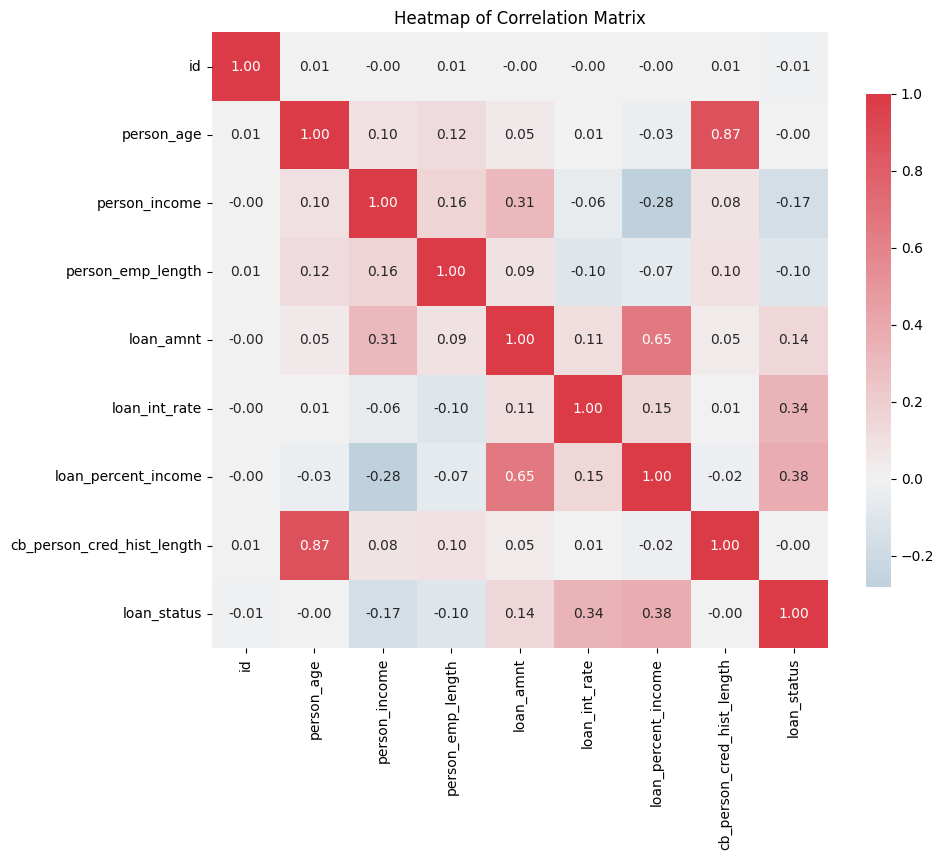

In [853]:
def plot_heatmap(df):
    # 数値データのみを抽出
    numeric_df = df.select_dtypes(include=['number'])

    # 相関行列を計算
    correlation_matrix = numeric_df.corr()

    # ヒートマップを描画
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap=sns.diverging_palette(240, 10, as_cmap=True),  # 青から赤のカラーマップ
        center=0,  # 中心を0に設定
        fmt='.2f',
        square=True,
        cbar_kws={"shrink": .8}
    )
    plt.title('Heatmap of Correlation Matrix')
    plt.show()

plot_heatmap(train)

# EDA用の関数

In [854]:
def normal_distribution_fit(df, col):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # カテゴリデータかどうかを判定
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        # カテゴリデータの場合
        sns.countplot(x=df[col], ax=ax[0])
        ax[0].set_title('Bar Plot of Categorical Data')
    else:
        # 数値データの場合
        sns.histplot(df[col], kde=True, stat='density', ax=ax[0])
        # 正規分布のフィット
        sns.histplot(df[col], stat='density', ax=ax[0], bins=30)
        x = np.linspace(df[col].min(), df[col].max(), 100)
        ax[0].plot(x, norm.pdf(x, df[col].mean(), df[col].std()), color='red')
        ax[0].set_title('Histogram with Normal Distribution Fit')

        # Q-Qプロット
        stats.probplot(df[col], plot=ax[1])
        ax[1].set_title('Q-Q Plot')

    plt.tight_layout()
    plt.show()

    # 数値データの場合のみスキューネスとカートシスを計算
    if df[col].dtype != 'object' and df[col].dtype.name != 'category':
        print(f"Skewness: {df[col].skew()}")
        print(f"Kurtosis: {df[col].kurt()}")

# person_age（年齢）

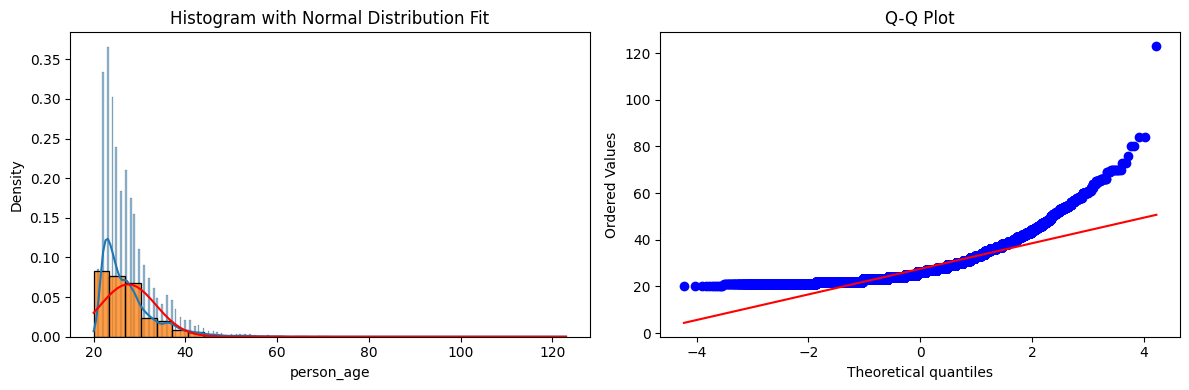

Skewness: 1.9654967033657
Kurtosis: 6.408379567393629


In [855]:
normal_distribution_fit(train, 'person_age')

1点だけ外れ値があり、グラフも横に長い。異常値の可能性あり。

In [856]:
# 大きい上から5つ
train_older = train.nlargest(5, "person_age")

# 小さい上から5つ
train_younger = train.nsmallest(5, "person_age")

display(train_older, train_younger)

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
47336,47336,123,36000,MORTGAGE,7.0,PERSONAL,B,6700,10.75,0.18,N,4,0
4962,4962,84,108928,MORTGAGE,3.0,DEBTCONSOLIDATION,A,6000,7.51,0.06,N,25,0
6750,6750,84,94800,MORTGAGE,2.0,PERSONAL,D,10000,14.09,0.11,N,22,0
15588,15588,80,54000,RENT,27.0,PERSONAL,A,10000,6.62,0.19,N,25,1
21953,21953,80,30000,RENT,7.0,MEDICAL,D,5000,14.96,0.17,N,24,1


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
8925,8925,20,38400,MORTGAGE,5.0,EDUCATION,A,15000,8.90,0.40,N,2,0
9688,9688,20,127000,MORTGAGE,2.0,DEBTCONSOLIDATION,D,24250,15.31,0.19,N,4,1
10525,10525,20,120000,MORTGAGE,4.0,MEDICAL,B,2500,9.99,0.02,N,4,0
11976,11976,20,95950,RENT,2.0,EDUCATION,D,28250,14.54,0.27,N,4,1
22043,22043,20,59000,RENT,1.0,PERSONAL,B,16800,12.42,0.29,N,2,1


In [857]:
# testデータも確認
test_older = test.nlargest(5, "person_age")
test_younger = test.nsmallest(5, "person_age")
display(test_older, test_younger)

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
33824,92469,94,56628,RENT,2.0,MEDICAL,E,16000,16.82,0.29,Y,27
32201,90846,84,60000,MORTGAGE,0.0,DEBTCONSOLIDATION,A,2000,5.79,0.03,N,25
2609,61254,70,36000,RENT,2.0,MEDICAL,C,5000,14.79,0.14,Y,24
5230,63875,70,42000,RENT,0.0,MEDICAL,D,5000,15.99,0.12,N,24
9649,68294,70,30000,RENT,1.0,MEDICAL,B,7500,10.96,0.25,N,24


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1760,60405,20,75000,RENT,2.0,EDUCATION,C,8000,14.22,0.11,N,3
4861,63506,20,65000,MORTGAGE,4.0,VENTURE,A,7000,6.99,0.11,N,3
17,58662,21,56004,OWN,2.0,VENTURE,B,6000,11.86,0.11,N,4
59,58704,21,44000,MORTGAGE,5.0,PERSONAL,C,5000,15.96,0.11,Y,4
107,58752,21,45000,RENT,5.0,EDUCATION,A,14000,6.91,0.31,N,3


年齢123歳は異常値に見える。実際の値の可能性があるが、モデルに対しては悪影響がある可能性があるため、ここでは外れ値として除外して進める。

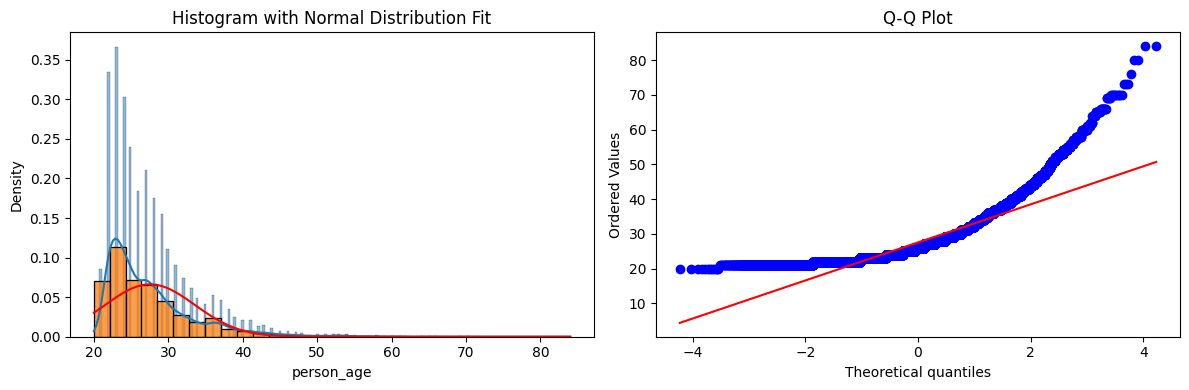

Skewness: 1.910983219833781
Kurtosis: 5.413603509016159


In [858]:
train_eda = train.copy()
train_eda = train_eda[train_eda["person_age"] < 100]
normal_distribution_fit(train_eda, 'person_age')

# person_income（収入）

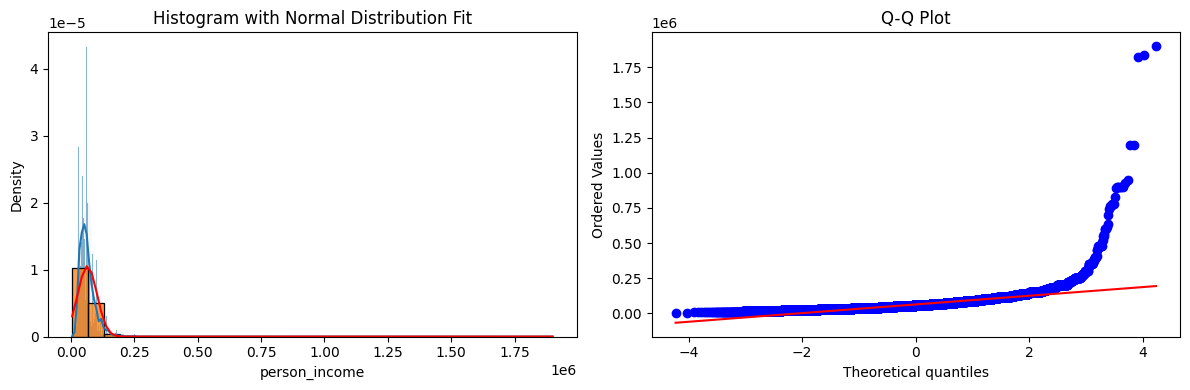

Skewness: 10.457722504927045
Kurtosis: 342.6293525072882


In [859]:
normal_distribution_fit(train, 'person_income')

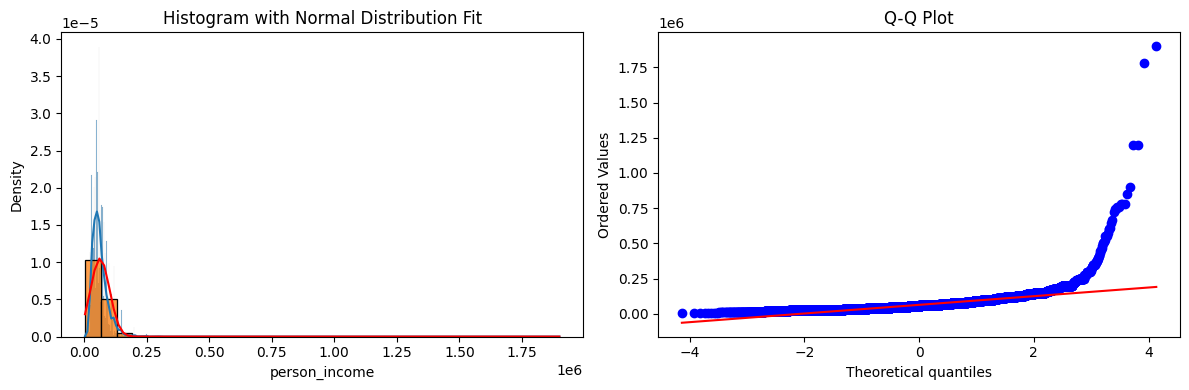

Skewness: 10.446479614755289
Kurtosis: 337.29215043588596


In [860]:
normal_distribution_fit(test, 'person_income')

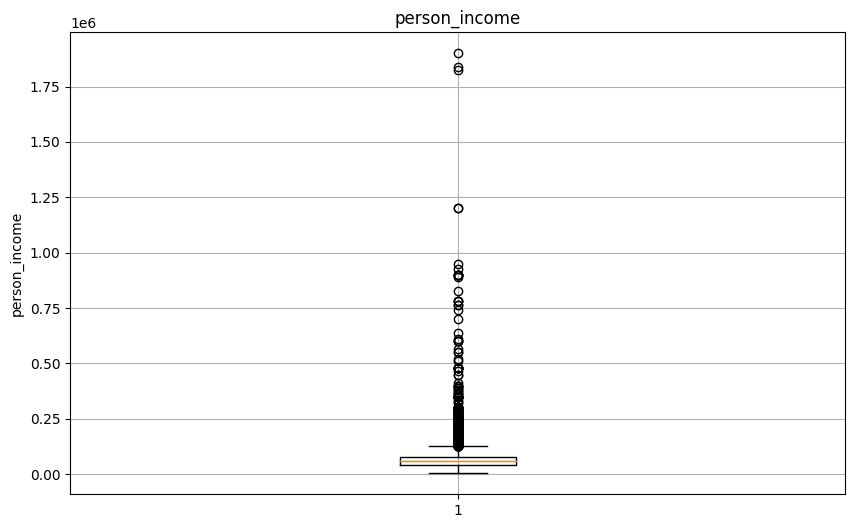

In [861]:
plt.figure(figsize=(10, 6))
plt.boxplot([train['person_income']])
plt.title('person_income')
plt.ylabel('person_income')
plt.grid()
plt.show()

In [862]:
train_richer = train.nlargest(10, "person_income")
train_poorer = train.nsmallest(5, "person_income")

display(train_richer, train_poorer)

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
17387,17387,22,1900000,MORTGAGE,6.0,EDUCATION,D,1500,15.62,0.00,Y,3,0
12404,12404,25,1839784,RENT,0.0,VENTURE,A,8000,8.00,0.04,N,3,0
37591,37591,29,1824000,MORTGAGE,8.0,DEBTCONSOLIDATION,C,6000,13.99,0.03,N,6,0
2093,2093,32,1200000,RENT,2.0,PERSONAL,A,10000,7.51,0.01,N,9,0
19060,19060,32,1200000,MORTGAGE,16.0,DEBTCONSOLIDATION,A,16000,6.92,0.13,N,5,0
11422,11422,29,948000,OWN,11.0,PERSONAL,B,4000,11.83,0.04,N,5,0
34752,34752,27,928000,MORTGAGE,8.0,VENTURE,C,2850,13.92,0.01,N,7,0
18465,18465,32,900000,RENT,13.0,PERSONAL,B,25000,11.49,0.03,N,5,0
31446,31446,26,900000,MORTGAGE,3.0,VENTURE,B,6000,9.91,0.01,N,3,0
37902,37902,35,900000,MORTGAGE,18.0,PERSONAL,B,4500,10.65,0.01,N,6,0


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
39716,39716,25,4200,RENT,5.0,MEDICAL,A,5000,6.760000,0.12,N,4,0
42581,42581,24,5000,RENT,0.0,EDUCATION,C,1000,13.060000,0.20,Y,4,0
1666,1666,36,9600,RENT,0.0,PERSONAL,E,2100,16.450001,0.22,N,16,1
8665,8665,22,9600,RENT,2.0,VENTURE,E,1750,17.430000,0.18,N,2,1
10435,10435,21,9600,RENT,1.0,PERSONAL,C,1000,12.680000,0.10,N,2,0


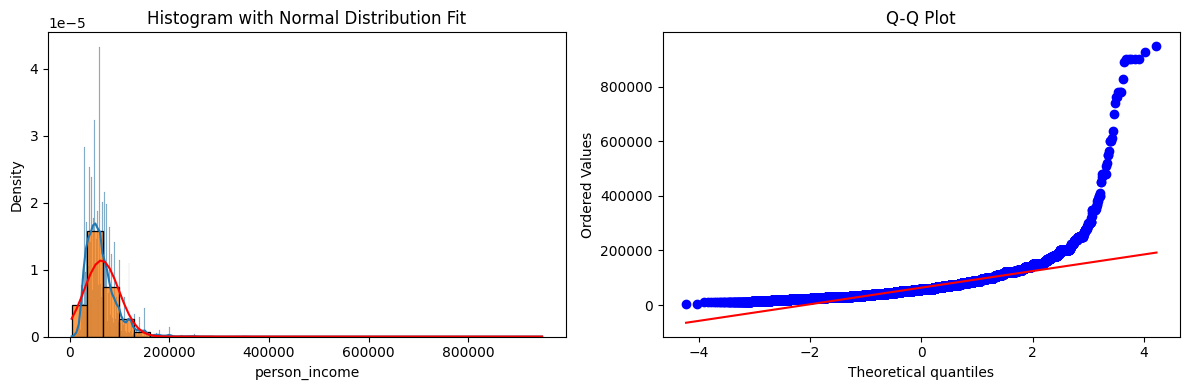

Skewness: 5.26311188988535
Kurtosis: 84.05022321872484


In [863]:
train_eda = train_eda[train_eda["person_income"] < 1000000]
normal_distribution_fit(train_eda, 'person_income')

1,000,000以上をしきい値として、外れ値とする。
ここはどこのラインがいいかが曖昧なので、後で比較評価してみる。
testデータにも同範囲の外れ値が存在しているので、決め打ちでも評価する。

# person_home_ownership（住宅所有状況）

In [864]:
train['person_home_ownership'] = train['person_home_ownership'].astype("category")

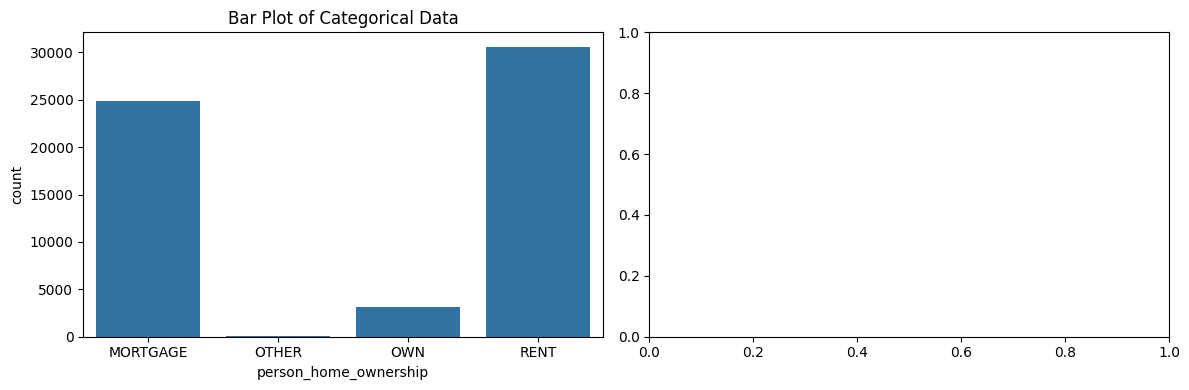

In [865]:
normal_distribution_fit(train, 'person_home_ownership')

[RENT：賃貸, OWN：持ち家, MORTGAGE：住宅ローンあり, OTHER：その他]

・持ち家は、賃貸よりも生活が安定している可能性が高いとみなされる。

・持ち家は固定資産であり、長期的な返済能力を示す要素となる。

・返済中の住宅ローンがあると、他の負債比率に影響を与える。

・持ち家は、家賃の支払いに対するリスクが少ないと見なされることが多い。

他のカラムとの組み合わせでより精度が上がりそう。

# person_emp_length: （雇用年数）

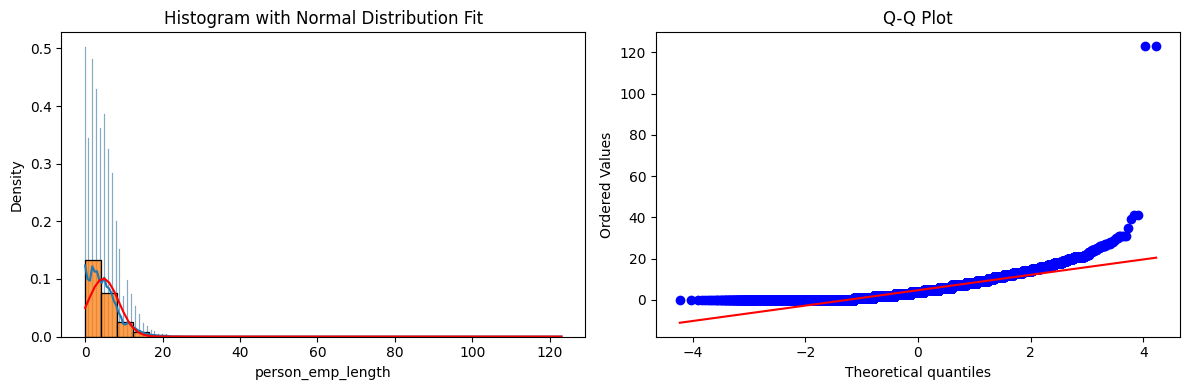

Skewness: 2.054429769515991
Kurtosis: 29.131607055664062


In [866]:
normal_distribution_fit(train, 'person_emp_length')

勤続年数100年以上は現実的にありえない。外れ値として削除。

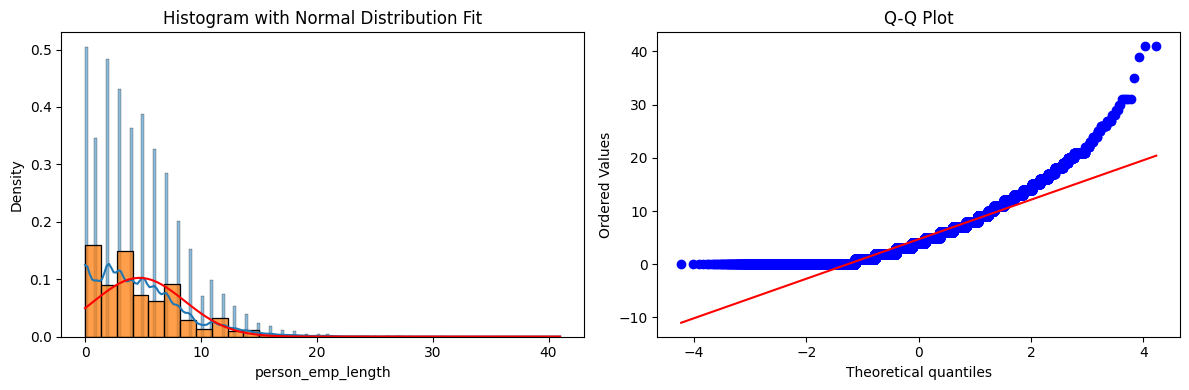

Skewness: 1.2025091648101807
Kurtosis: 2.2834019660949707


In [867]:
train_eda['person_emp_length'] = train_eda['person_emp_length'].astype('float32')
train_eda = train_eda[train_eda["person_emp_length"] < 50]
normal_distribution_fit(train_eda, 'person_emp_length')

現在の会社の勤続年数を示している。社会人年数などの指標があればそれも有効かも。

# loan_intent（ローンの目的）

In [868]:
train['loan_intent'].unique()

['EDUCATION', 'MEDICAL', 'PERSONAL', 'VENTURE', 'DEBTCONSOLIDATION', 'HOMEIMPROVEMENT']
Categories (6, object): ['DEBTCONSOLIDATION', 'EDUCATION', 'HOMEIMPROVEMENT', 'MEDICAL', 'PERSONAL',
                         'VENTURE']

['EDUCATION'：教育, 'MEDICAL'：医療, 'PERSONAL'個人的な用途, 'VENTURE'：事業, 'DEBTCONSOLIDATION'：借入金の整理, 'HOMEIMPROVEMENT'：住宅改修]

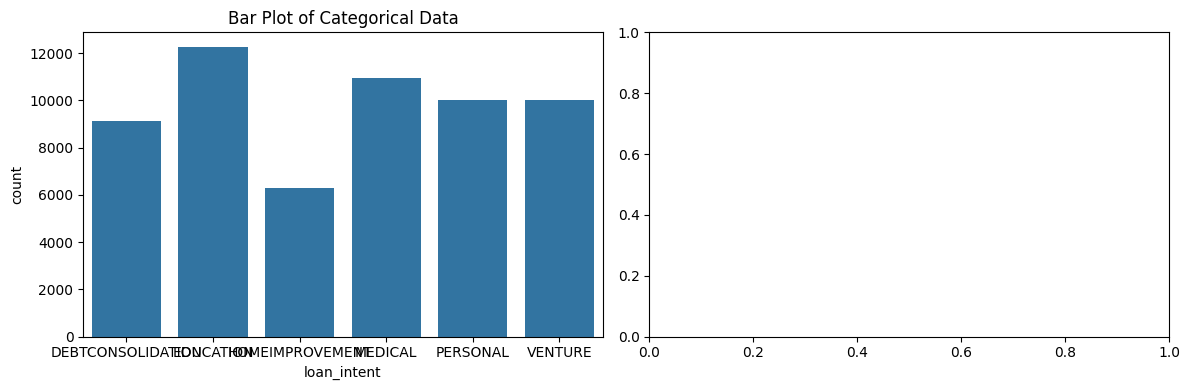

In [869]:
normal_distribution_fit(train, 'loan_intent')

カテゴリ型から数値型に変換すると良い点などあれば、変更する

# loan_grade（信用リスクの評価）

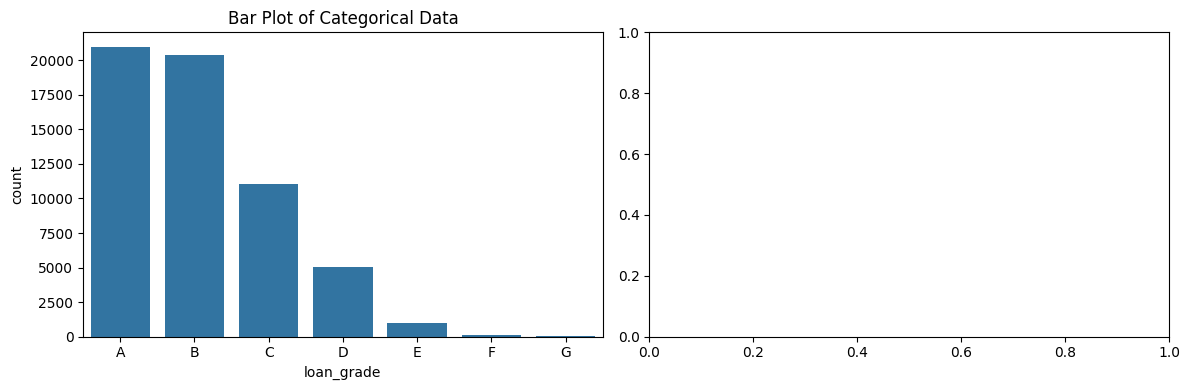

In [870]:
normal_distribution_fit(train, 'loan_grade')

# loan_amnt（ローン金額）

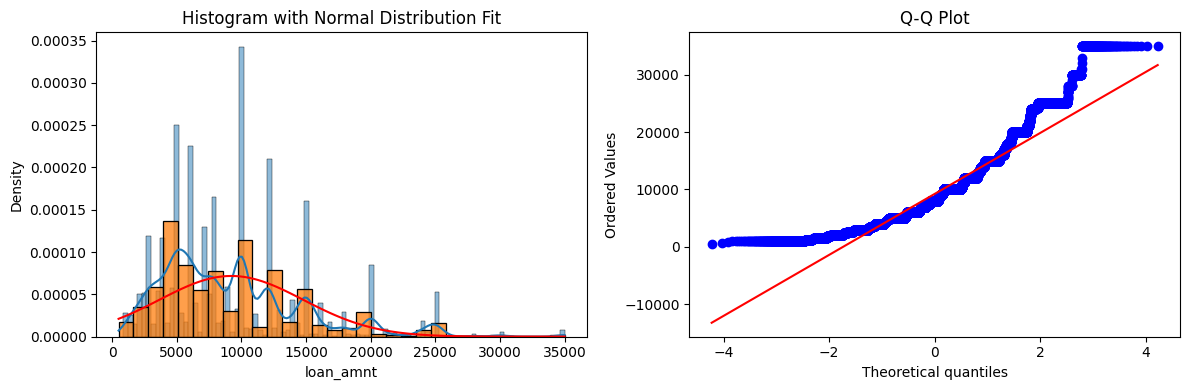

Skewness: 1.1885784743437686
Kurtosis: 1.6937836745265122


In [871]:
normal_distribution_fit(train, 'loan_amnt')

In [872]:
train_higher = train.nlargest(5, "loan_amnt")
train_lower = train.nsmallest(5, "loan_amnt")

display(train_higher, train_lower)

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
249,249,29,100000,MORTGAGE,6.0,DEBTCONSOLIDATION,C,35000,12.730000,0.35,Y,8,0
744,744,23,108000,RENT,3.0,VENTURE,D,35000,15.620000,0.32,N,2,1
837,837,24,104000,MORTGAGE,8.0,MEDICAL,C,35000,14.270000,0.34,Y,4,0
932,932,23,85000,MORTGAGE,7.0,EDUCATION,B,35000,10.650000,0.39,N,2,0
967,967,35,150000,RENT,19.0,PERSONAL,E,35000,18.389999,0.23,Y,6,0


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
51379,51379,27,29000,RENT,3.0,VENTURE,C,500,12.840000,0.02,N,8,0
29600,29600,24,24000,RENT,1.0,MEDICAL,A,700,6.760000,0.03,N,4,0
44958,44958,22,57000,RENT,0.0,MEDICAL,C,900,11.410000,0.02,N,4,0
281,281,37,42000,RENT,11.0,PERSONAL,B,1000,9.760000,0.02,N,16,0
733,733,28,24000,RENT,1.0,DEBTCONSOLIDATION,D,1000,16.290001,0.04,N,8,1


異常値は特になし。
ざっくり金額だと審査に影響あったりする？

# loan_int_rate（ローン金利）

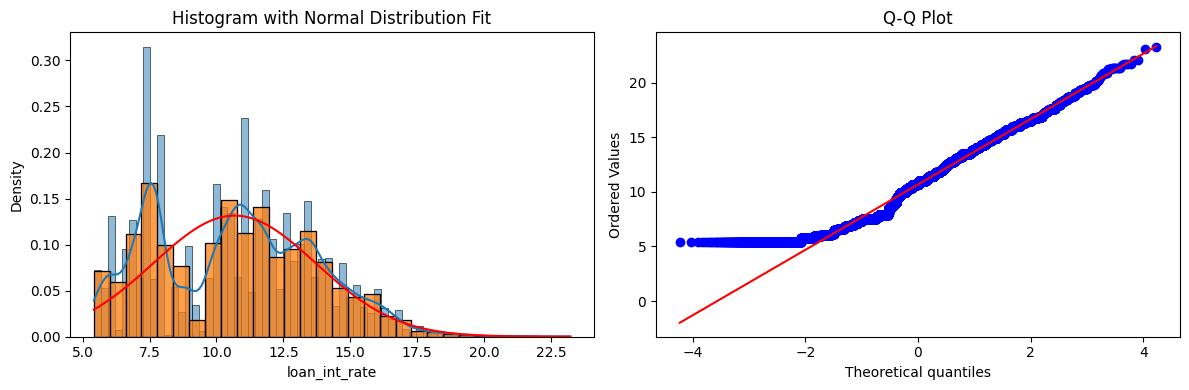

Skewness: 0.20002025365829468
Kurtosis: -0.7181533575057983


In [873]:
normal_distribution_fit(train, 'loan_int_rate')

ローン金利も含めた総額の指標もありか！

# loan_percent_income（ローン金額/収入）

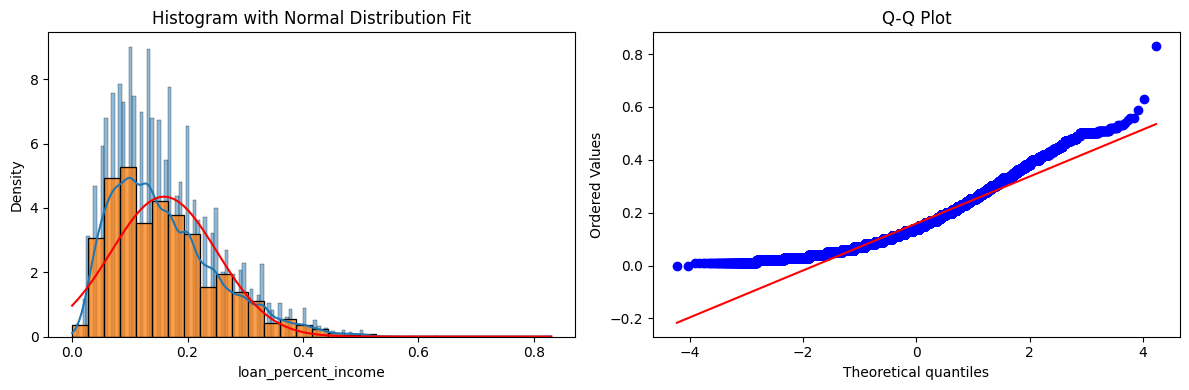

Skewness: 0.9174728393554688
Kurtosis: 0.6313422918319702


In [874]:
normal_distribution_fit(train, 'loan_percent_income')

In [875]:
# train_eda['loanpercent_checker'] = train["loan_percent_income"] - train["loan_amnt"] / train["person_income"]
# print(train_eda['loanpercent_checker'].describe())
# sns.lineplot(train_eda['loanpercent_checker'])

-2.5のズレは明らかにおかしい。qualが1%と99%は外れ値として削除する。

In [876]:
# # 1%と99%のパーセンタイルを計算
# lower_bound = train_eda['loanpercent_checker'].quantile(0.01)  # 1パーセンタイル
# upper_bound = train_eda['loanpercent_checker'].quantile(0.99)  # 99パーセンタイル

# # 指定した範囲外のデータを削除
# train_eda = train_eda[(train_eda['loanpercent_checker'] >= lower_bound) & (train_eda['loanpercent_checker'] <= upper_bound)]

# print(train_eda['loanpercent_checker'].describe())
# sns.lineplot(train_eda['loanpercent_checker'])

In [877]:
train_loanpercent_higher = train.nlargest(5, "loan_percent_income")
train_loanpercent_lower = train.nsmallest(5, "loan_percent_income")

display(train_loanpercent_higher, train_loanpercent_lower)

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
49179,49179,39,12000,RENT,0.0,PERSONAL,C,16000,10.780000,0.83,N,12,1
56034,56034,35,40000,OWN,1.0,HOMEIMPROVEMENT,B,25000,11.860000,0.63,N,8,0
54980,54980,22,69000,RENT,0.0,VENTURE,D,3775,18.250000,0.59,N,4,1
21747,21747,36,18000,RENT,0.0,HOMEIMPROVEMENT,E,12000,18.389999,0.56,Y,12,1
44806,44806,40,14400,RENT,2.0,HOMEIMPROVEMENT,C,8000,14.270000,0.56,N,15,1


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
17387,17387,22,1900000,MORTGAGE,6.0,EDUCATION,D,1500,15.62,0.00,Y,3,0
50049,50049,24,30000,MORTGAGE,1.0,DEBTCONSOLIDATION,A,3200,8.07,0.00,N,4,0
91,91,24,225000,RENT,0.0,MEDICAL,C,3000,14.26,0.01,Y,2,0
677,677,30,100000,MORTGAGE,7.0,EDUCATION,A,1200,8.32,0.01,N,8,0
2093,2093,32,1200000,RENT,2.0,PERSONAL,A,10000,7.51,0.01,N,9,0


# cb_person_default_on_file（デフォルト有無）

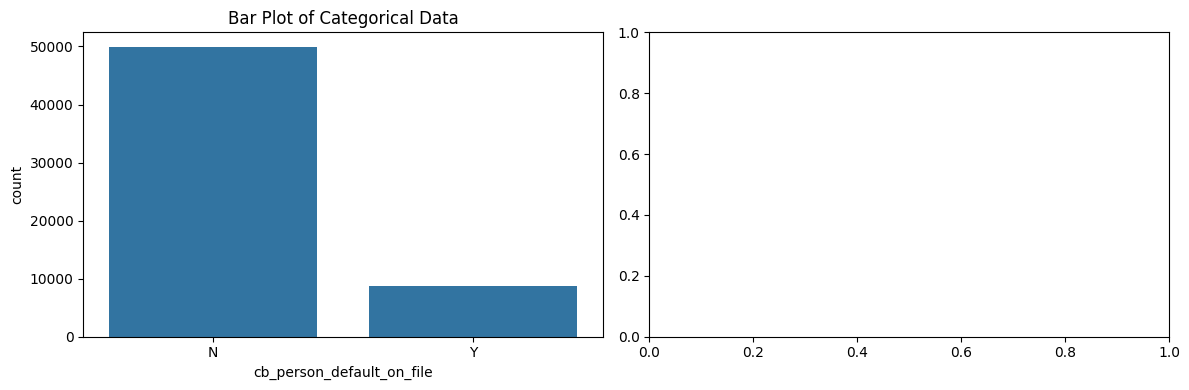

In [878]:
normal_distribution_fit(train, 'cb_person_default_on_file')

異常値もないし、特に追加もなし

# cb_person_cred_hist_length（信用履歴の長さ）

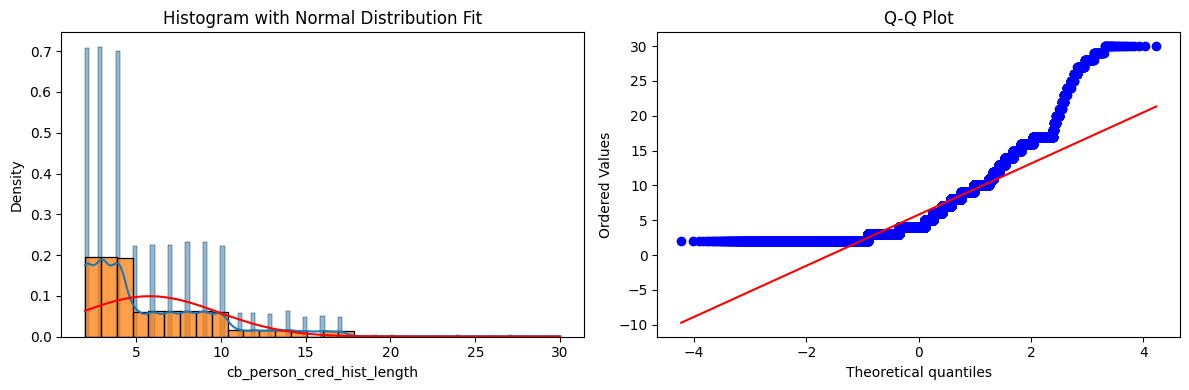

Skewness: 1.6185028956126892
Kurtosis: 3.4907748950955466


In [879]:
normal_distribution_fit(train, 'cb_person_cred_hist_length')

count    58637.000000
mean         4.735594
std          3.157308
min        -18.000000
25%          3.000000
50%          4.000000
75%          6.000000
max         45.000000
Name: person_cred_checker, dtype: float64


<Axes: ylabel='person_cred_checker'>

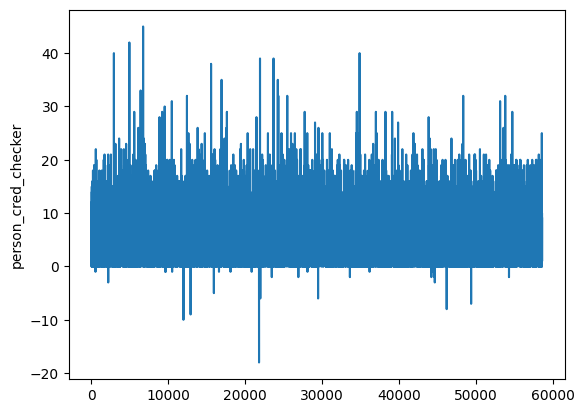

In [880]:
# デフォルトが正しいかのチェック（借入可能は18歳以上としている）
train_eda['person_cred_checker'] = train["person_age"] - 17 - train["cb_person_cred_hist_length"]
print(train_eda['person_cred_checker'].describe())
sns.lineplot(train_eda['person_cred_checker'])

借り入れ可能な年齢よりもデフォルト年数が長いにフラグを付ける

In [881]:
train_eda['person_cred_checker'] = train_eda['person_cred_checker'].apply(lambda x: 1 if x < 0 else 0)
train_eda['person_cred_checker'].head()

,person_cred_checker
0,0
1,0
2,0
3,0
4,0


# 追加したカラム

In [882]:
# train_eda['person_cred_checker'] = train["person_age"] - 17 - train["cb_person_cred_hist_length"]
# train_eda['person_cred_checker'] = train_eda['person_cred_checker'].apply(lambda x: 1 if x < 0 else 0)

# LightGBMモデル

In [883]:
train_eda.columns

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status', 'person_cred_checker'],
      dtype='object')

In [884]:
x_train = train_eda.drop(columns=["id", "loan_status"])
y_train = train_eda["loan_status"]
id_train = train_eda["id"]

In [885]:
x_train.dtypes

,0
person_age,int64
person_income,int64
person_home_ownership,category
person_emp_length,float32
loan_intent,category
loan_grade,category
loan_amnt,int64
loan_int_rate,float32
loan_percent_income,float32
cb_person_default_on_file,category


In [886]:
print("mean: {:.4f}".format(y_train.mean()))
y_train.value_counts()

mean: 0.1424


,count
loan_status,
0,50288
1,8349


In [887]:
import numpy as np
import pandas as pd
import pickle
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import matplotlib.pyplot as plt

def calculate_youden_j(fpr, tpr, thresholds):
    """YoudenのJ統計量を計算し、最適なしきい値を見つける関数"""
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    optimal_threshold = thresholds[optimal_idx]
    max_youden_j = youden_j[optimal_idx]
    return optimal_idx, optimal_threshold, max_youden_j

def plot_roc_curves(roc_curves, thresholds, nfolds):
    """ROC曲線を描画する関数"""
    plt.figure(figsize=(10, 6))
    for i, (fpr, tpr) in enumerate(roc_curves):
        plt.plot(fpr, tpr, lw=1, label=f'Fold {i}')  # 各フォールドのROC曲線をプロット

    plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Guess')  # ランダム予測の基準線

    # YoudenのJ統計量の計算とプロット
    for i, (fpr, tpr) in enumerate(roc_curves):
        optimal_idx, optimal_threshold, max_youden_j = calculate_youden_j(fpr, tpr, thresholds[i])
        plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o',
                    label=f'Fold {i} Optimal J: {max_youden_j:.2f}, Threshold: {optimal_threshold:.2f}')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Cross-Validation')
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()

def train_lgb(input_x, input_y, input_id, params, list_nfold=[0, 1, 2, 3, 4], n_splits=5):
    train_oof = np.zeros(len(input_x))
    metrics = []
    imp = pd.DataFrame()
    roc_curves = []  # ROC曲線データを保存するリスト
    thresholds_list = []  # しきい値を保存するリスト

    # クロスバリデーションの設定
    cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(input_x, input_y))

    for nfold in list_nfold:
        print("-" * 20, nfold, "-" * 20)

        # データセットの分割
        idx_tr, idx_va = cv[nfold]
        x_tr, y_tr = input_x.iloc[idx_tr], input_y.iloc[idx_tr]
        x_va, y_va = input_x.iloc[idx_va], input_y.iloc[idx_va]
        print("Train shape:", x_tr.shape, "Validation shape:", x_va.shape)

        # モデルのトレーニング
        model = LGBMClassifier(**params)
        model.fit(
            x_tr, y_tr,
            eval_set=[(x_tr, y_tr), (x_va, y_va)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)]
        )

        # モデルの保存
        fname_lgb = "model_lgb_fold{}.pickle".format(nfold)
        with open(fname_lgb, "wb") as f:
            pickle.dump(model, f, protocol=4)

        # 評価
        y_tr_pred = model.predict_proba(x_tr)[:, 1]
        y_va_pred = model.predict_proba(x_va)[:, 1]
        metric_tr = roc_auc_score(y_tr, y_tr_pred)
        metric_va = roc_auc_score(y_va, y_va_pred)
        metrics.append([nfold, metric_tr, metric_va])
        print("[AUC] Train: {:.4f}, Validation: {:.4f}".format(metric_tr, metric_va))

        # Out-of-Fold予測
        train_oof[idx_va] = y_va_pred

        # ROC曲線のデータを保存
        fpr, tpr, thresholds = roc_curve(y_va, y_va_pred)
        roc_curves.append((fpr, tpr))
        thresholds_list.append(thresholds)

        # 最適なしきい値を計算して出力
        optimal_idx, optimal_threshold, max_youden_j = calculate_youden_j(fpr, tpr, thresholds)
        print(f"[Fold {nfold}] Optimal Threshold: {optimal_threshold:.4f}, J: {max_youden_j:.4f}")

        # 特徴量の重要度
        _imp = pd.DataFrame({"col": input_x.columns, "imp": model.feature_importances_, "nfold": nfold})
        imp = pd.concat([imp, _imp])

    print("-" * 20, "Result", "-" * 20)

    # メトリックの表示
    metrics = np.array(metrics)
    print(metrics)
    print("[CV] Train: {:.4f} ± {:.4f}, Validation: {:.4f} ± {:.4f}".format(
        metrics[:, 1].mean(), metrics[:, 1].std(),
        metrics[:, 2].mean(), metrics[:, 2].std(),
    ))
    print("[OOF] {:.4f}".format(roc_auc_score(input_y, train_oof)))

    # Out-of-Fold DataFrame
    train_oof_df = pd.concat([input_id.reset_index(drop=True), pd.DataFrame({"pred": train_oof})], axis=1)

    # 特徴量の重要度を集計
    imp = imp.groupby("col")["imp"].agg(["mean", "std"]).reset_index(drop=False)
    imp.columns = ["col", "imp", "imp_std"]

    # ROC曲線を描画
    plot_roc_curves(roc_curves, thresholds_list, len(list_nfold))

    return train_oof_df, imp, metrics

-------------------- 0 --------------------
Train shape: (46909, 12) Validation shape: (11728, 12)
[LightGBM] [Info] Number of positive: 6679, number of negative: 40230
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 46909, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142382 -> initscore=-1.795645
[LightGBM] [Info] Start training from score -1.795645
[AUC] Train: 0.9787, Validation: 0.9589
[Fold 0] Optimal Threshold: 0.1182, J: 0.7837
-------------------- 1 --------------------
Train shape: (46909, 12) Validation shape: (11728, 12)
[LightGBM] [Info] Number of positive: 6679, number of negative: 40230
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.00

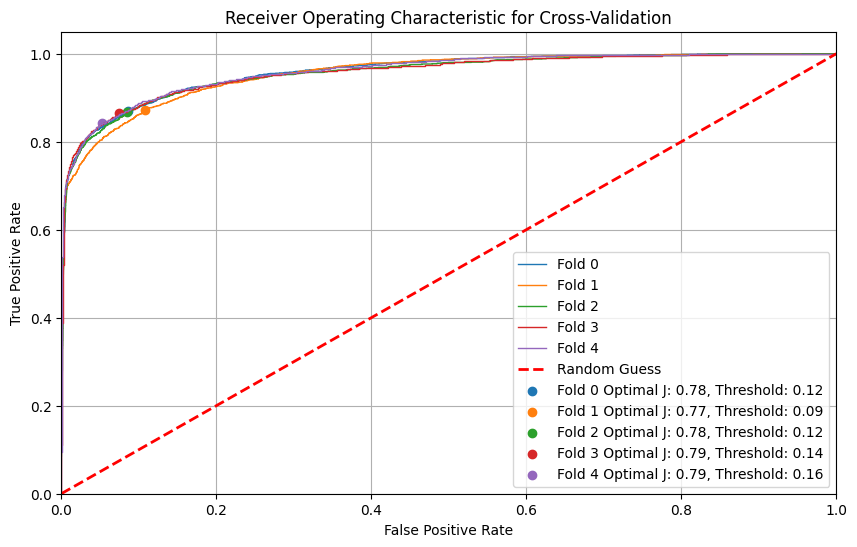

In [888]:
#ハイパーパラメータの設定
params = {
'boosting_type': 'gbdt',
'objective': 'binary',
'metric': 'auc',
'learning_rate': 0.05,
'num_leaves': 32,
'n_estimators': 100000,
"random_state": 123,
"importance_type": "gain",
}
# 学習の実行
train_oof, imp, metrics = train_lgb(
    x_train,
    y_train,
    id_train,
    params,
    list_nfold=[0, 1, 2, 3, 4],
    n_splits=5,
)

In [889]:
imp.sort_values("imp", ascending=False)[:10]

,col,imp,imp_std
6,loan_percent_income,84722.733469,1493.476565
3,loan_grade,71554.578466,945.493749
11,person_income,37273.605401,2358.496038
10,person_home_ownership,33714.385917,566.716129
4,loan_int_rate,17208.646562,1662.162922
5,loan_intent,15114.521196,361.235580
9,person_emp_length,12676.500204,1259.700591
7,person_age,5343.789403,1349.668798
2,loan_amnt,5315.735088,1052.228426
0,cb_person_cred_hist_length,2347.008671,702.817090


# testデータの予測

In [890]:
test['person_cred_checker'] = test["person_age"] - 17 - test["cb_person_cred_hist_length"]
test['person_cred_checker'] = test['person_cred_checker'].apply(lambda x: 1 if x < 0 else 0)

In [891]:
x_test = test.drop(columns=["id"])
test_id = test["id"]

for col in x_test.columns:
    if x_test[col].dtype == "object":
        x_test[col] = x_test[col].astype("category")

In [892]:
with open("model_lgb_fold0.pickle", "rb") as f:
  model = pickle.load(f)

y_test_pred = model.predict_proba(x_test)[:, 1]

test_pred = np.zeros((len(x_test), 5))
test_pred[:, 0] = y_test_pred

test_pred_mean = test_pred.mean(axis=1)

test_pred_mean = pd.DataFrame({"id": test_id, "pred": test_pred_mean})
test_pred_mean.head()

,id,pred
0,58645,0.197407
1,58646,0.003140
2,58647,0.132343
3,58648,0.002430
4,58649,0.015385


In [903]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39098 non-null  int64  
 1   person_age                  39098 non-null  int64  
 2   person_income               39098 non-null  int64  
 3   person_home_ownership       39098 non-null  object 
 4   person_emp_length           39098 non-null  float64
 5   loan_intent                 39098 non-null  object 
 6   loan_grade                  39098 non-null  object 
 7   loan_amnt                   39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_default_on_file   39098 non-null  object 
 11  cb_person_cred_hist_length  39098 non-null  int64  
 12  person_cred_checker         39098 non-null  int64  
dtypes: float64(3), int64(6), object

In [902]:
test_pred_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      39098 non-null  int64  
 1   pred    39098 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 611.0 KB


# 提出データの作成

In [893]:
df_submit = pd.DataFrame({
    'id': test_pred_mean["id"],
    'loan_status': test_pred_mean["pred"]
})

df_submit.head()

,id,loan_status
0,58645,0.197407
1,58646,0.003140
2,58647,0.132343
3,58648,0.002430
4,58649,0.015385


In [904]:
df_submit.to_csv("submission_loanstatus_1.csv", index=False)

github用：lightgbm_eda